# Process Data

Extract data for 3 sites from each parquet file.

Reformat to wide dataframe.

Resample to X-minute.

Add features.

Min/Max scaler.

Save to /processed/

## Imports and Setup

In [68]:
from pathlib import Path
import pandas as pd
import numpy as np
import joblib
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
import hvplot.pandas
import matplotlib.pyplot as plt
from dotenv import dotenv_values
import holoviews as hv
from IPython.display import Image

In [2]:
cfg = dotenv_values()

In [3]:
root_dir = Path(cfg['root_dir'])
data_dir = Path(cfg['data_dir'])

In [4]:
pqdir = data_dir / 'interim'

## Extract data for sites

upstream site   = 447_2_351

main site       = 446_1_350

downstream site = 446_3_349

In [5]:
sites = ['447_2_351', '446_1_350', '446_3_349']

In [7]:
all_results = []
all_pq = pqdir.glob('*.pq')
i = 0
for this_pq in all_pq:
    #print(i, end=', ')
    df = pd.read_parquet(this_pq)

    # site: 446_1_350
    a = df[(df['detector_id'] == sites[1]) & (df['detector_lane_number'] == 1)][['timestamp', 'lane_vehicle_speed', 'lane_vehicle_count', 'occupancy']]
    
    if not a.empty:
        a.index = [0]

        # upstream site: 447_2_351
        us = df[(df['detector_id'] == sites[0]) & (df['detector_lane_number'] == 1)][['lane_vehicle_speed', 'lane_vehicle_count', 'occupancy']]
        if us.empty:
            us = pd.DataFrame([[np.nan, np.nan, np.nan]], columns=['us_lane_vehicle_speed', 'us_lane_vehicle_count', 'us_occupancy'])
            print('us empty')
        else:
            us.index = [0]

        # downstream site: 446_3_349
        ds = df[(df['detector_id'] == sites[2]) & (df['detector_lane_number'] == 1)][['lane_vehicle_speed', 'lane_vehicle_count', 'occupancy']]
        if ds.empty:
            ds = pd.DataFrame([[np.nan, np.nan, np.nan]], columns=['ds_lane_vehicle_speed', 'ds_lane_vehicle_count', 'ds_occupancy'])
            print('ds empty')
        else:
            ds.index = [0]


    D = pd.concat([a, us, ds], axis=1, ignore_index=True)

    all_results.append(D)
    
    i += 1
    
D2 = pd.concat(all_results)
D2.columns = ['timestamp', 'lane_vehicle_speed', 'lane_vehicle_count', 'occupancy', \
              'ds_lane_vehicle_speed', 'ds_lane_vehicle_count', 'ds_occupancy', 'us_lane_vehicle_speed', 'us_lane_vehicle_count', 'us_occupancy']


In [8]:
D2 = pd.concat(all_results)
D2.columns = ['timestamp', 'lane_vehicle_speed', 'lane_vehicle_count', 'occupancy', \
              'ds_lane_vehicle_speed', 'ds_lane_vehicle_count', 'ds_occupancy', 'us_lane_vehicle_speed', 'us_lane_vehicle_count', 'us_occupancy']

In [9]:
D2.set_index('timestamp', inplace=True)
D2 = D2[~D2.index.duplicated(keep='first')]
D2.head()

lane_vehicle_speed  lane_vehicle_count  occupancy  \
timestamp                                                                
2021-10-26 20:01:27               100.0                 1.0        0.0   
2021-10-26 20:02:27                79.0                 3.0        0.0   
2021-10-26 20:03:27                88.0                 9.0        2.0   
2021-10-26 20:04:27                86.0                 3.0        0.0   
2021-10-26 20:05:27                79.0                 2.0        0.0   

                     ds_lane_vehicle_speed  ds_lane_vehicle_count  \
timestamp                                                           
2021-10-26 20:01:27                     82                      3   
2021-10-26 20:02:27                     86                      7   
2021-10-26 20:03:27                     88                      2   
2021-10-26 20:04:27                     81                      2   
2021-10-26 20:05:27                     85                      4   

                     ds_occupancy  us_lane_vehicle_speed  \
timestamp                                                  
2021-10-26 20:01:27             0                     74   
2021-10-26 20:02:27             2                     91   
2021-10-26 20:03:27             0                     81   
2021-10-26 20:04:27             0                     84   
2021-10-26 20:05:27             1                     84   

                     us_lane_vehicle_count  us_occupancy  
timestamp                                                 
2021-10-26 20:01:27                      2             0  
2021-10-26 20:02:27                      1             0  
2021-10-26 20:03:27                      6             2  
2021-10-26 20:04:27                      7             2  
2021-10-26 20:05:27                      2             0

In [10]:
D2.tail()

lane_vehicle_speed  lane_vehicle_count  occupancy  \
timestamp                                                                
2021-11-16 10:11:06                80.0                 1.0        0.0   
2021-11-16 10:12:06               149.0                 0.0        0.0   
2021-11-16 10:13:06                89.0                 1.0        0.0   
2021-11-16 10:14:06                81.0                 4.0        1.0   
2021-11-16 10:15:06                78.0                 4.0        1.0   

                     ds_lane_vehicle_speed  ds_lane_vehicle_count  \
timestamp                                                           
2021-11-16 10:11:06                    149                      0   
2021-11-16 10:12:06                     92                      1   
2021-11-16 10:13:06                     86                      5   
2021-11-16 10:14:06                     86                      5   
2021-11-16 10:15:06                     81                      8   

                     ds_occupancy  us_lane_vehicle_speed  \
timestamp                                                  
2021-11-16 10:11:06             0                     91   
2021-11-16 10:12:06             0                     80   
2021-11-16 10:13:06             1                     89   
2021-11-16 10:14:06             1                     83   
2021-11-16 10:15:06             2                     82   

                     us_lane_vehicle_count  us_occupancy  
timestamp                                                 
2021-11-16 10:11:06                      2             0  
2021-11-16 10:12:06                      1             0  
2021-11-16 10:13:06                      1             0  
2021-11-16 10:14:06                      1             0  
2021-11-16 10:15:06                      5             1

In [11]:
D2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26268 entries, 2021-10-26 20:01:27 to 2021-11-16 10:15:06
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   lane_vehicle_speed     26267 non-null  float64
 1   lane_vehicle_count     26267 non-null  float64
 2   occupancy              26267 non-null  float64
 3   ds_lane_vehicle_speed  26268 non-null  int64  
 4   ds_lane_vehicle_count  26268 non-null  int64  
 5   ds_occupancy           26268 non-null  int64  
 6   us_lane_vehicle_speed  26268 non-null  int64  
 7   us_lane_vehicle_count  26268 non-null  int64  
 8   us_occupancy           26268 non-null  int64  
dtypes: float64(3), int64(6)
memory usage: 2.0 MB


In [12]:
# clean
#   speeds > 120 = np.nan
idx1 = D2['lane_vehicle_speed'] > 119
idx2 = D2['ds_lane_vehicle_speed'] > 119
idx3 = D2['us_lane_vehicle_speed'] > 119

In [13]:
print(idx1.sum(), idx2.sum(), idx3.sum())

2550 2535 2641


In [14]:
D2.loc[idx1, 'lane_vehicle_speed'] = np.nan
D2.loc[idx2, 'ds_lane_vehicle_speed'] = np.nan
D2.loc[idx3, 'us_lane_vehicle_speed'] = np.nan

In [15]:
D2.shape

(26268, 9)

In [16]:
# sort by index
D2.sort_index(inplace=True)

In [17]:
#D2.to_excel(Path('c:/projects/nrel-presentation/working/D2.xlsx'))

In [17]:
# plot
D2.hvplot.line(y='lane_vehicle_speed', use_index=True, width=1300)

:Curve   [timestamp]   (lane_vehicle_speed)

<Figure size 1920x960 with 0 Axes>

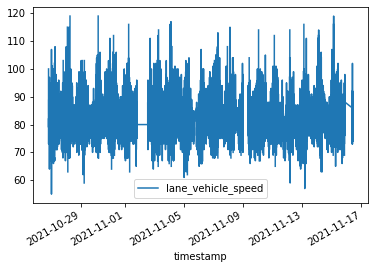

In [31]:
fig = plt.figure(figsize=(16,8), dpi=120)
D2.plot(y='lane_vehicle_speed', use_index=True, backend='matplotlib')
plt.show()

## Fill in Gaps

In [32]:
# 11/01 and 11/02
#  fill in this data with same hours from previous day
#   missing from 2021-11-01 19:36 to 2021-11-02 13:02
#   repeat data from 2021-10-31 19:36 to 2021-11-01 13:02
D2.loc['2021-10-31 19:35' : '2021-11-01 13:03']

C:\Users\David\AppData\Local\Temp/ipykernel_6288/2187780894.py:5: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  D2.loc['2021-10-31 19:35' : '2021-11-01 13:03']


lane_vehicle_speed  lane_vehicle_count  occupancy  \
timestamp                                                                
2021-10-31 19:35:21                86.0                 7.0        1.0   
2021-10-31 19:36:21                87.0                 7.0        1.0   
2021-10-31 19:37:21                79.0                 9.0        2.0   
2021-10-31 19:38:21                82.0                 6.0        1.0   
2021-10-31 19:39:21                80.0                 7.0        2.0   
...                                 ...                 ...        ...   
2021-11-01 12:59:14                84.0                10.0        3.0   
2021-11-01 13:00:14                86.0                 2.0        0.0   
2021-11-01 13:01:14                86.0                 5.0        1.0   
2021-11-01 13:02:14                82.0                25.0        7.0   
2021-11-01 13:03:14                88.0                10.0        2.0   

                     ds_lane_vehicle_speed  ds_lane_vehicle_count  \
timestamp                                                           
2021-10-31 19:35:21                   86.0                      8   
2021-10-31 19:36:21                   82.0                      3   
2021-10-31 19:37:21                   85.0                      6   
2021-10-31 19:38:21                   80.0                      9   
2021-10-31 19:39:21                   82.0                      1   
...                                    ...                    ...   
2021-11-01 12:59:14                   87.0                      6   
2021-11-01 13:00:14                   82.0                     17   
2021-11-01 13:01:14                   79.0                     13   
2021-11-01 13:02:14                   89.0                      8   
2021-11-01 13:03:14                   85.0                      7   

                     ds_occupancy  us_lane_vehicle_speed  \
timestamp                                                  
2021-10-31 19:35:21             2                   84.0   
2021-10-31 19:36:21             1                   84.0   
2021-10-31 19:37:21             1                   89.0   
2021-10-31 19:38:21             3                   79.0   
2021-10-31 19:39:21             0                   78.0   
...                           ...                    ...   
2021-11-01 12:59:14             1                   78.0   
2021-11-01 13:00:14             5                   80.0   
2021-11-01 13:01:14             4                   80.0   
2021-11-01 13:02:14             2                   78.0   
2021-11-01 13:03:14             2                   79.0   

                     us_lane_vehicle_count  us_occupancy  
timestamp                                                 
2021-10-31 19:35:21                      8             2  
2021-10-31 19:36:21                      8             2  
2021-10-31 19:37:21                      3             0  
2021-10-31 19:38:21                      8             3  
2021-10-31 19:39:21                      6             2  
...                                    ...           ...  
2021-11-01 12:59:14                     19             7  
2021-11-01 13:00:14                      8             3  
2021-11-01 13:01:14                      4             1  
2021-11-01 13:02:14                     10             4  
2021-11-01 13:03:14                     18             7  

[1011 rows x 9 columns]

In [33]:
# add a day
newdf = D2.loc['2021-10-31 19:35' : '2021-11-01 13:03'].copy()
newindex = newdf.index.values
newdf.index = pd.DatetimeIndex([dt + pd.Timedelta('1D') for dt in newindex])
newdf.head()

C:\Users\David\AppData\Local\Temp/ipykernel_6288/984216267.py:2: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  newdf = D2.loc['2021-10-31 19:35' : '2021-11-01 13:03'].copy()


lane_vehicle_speed  lane_vehicle_count  occupancy  \
2021-11-01 19:35:21                86.0                 7.0        1.0   
2021-11-01 19:36:21                87.0                 7.0        1.0   
2021-11-01 19:37:21                79.0                 9.0        2.0   
2021-11-01 19:38:21                82.0                 6.0        1.0   
2021-11-01 19:39:21                80.0                 7.0        2.0   

                     ds_lane_vehicle_speed  ds_lane_vehicle_count  \
2021-11-01 19:35:21                   86.0                      8   
2021-11-01 19:36:21                   82.0                      3   
2021-11-01 19:37:21                   85.0                      6   
2021-11-01 19:38:21                   80.0                      9   
2021-11-01 19:39:21                   82.0                      1   

                     ds_occupancy  us_lane_vehicle_speed  \
2021-11-01 19:35:21             2                   84.0   
2021-11-01 19:36:21             1                   84.0   
2021-11-01 19:37:21             1                   89.0   
2021-11-01 19:38:21             3                   79.0   
2021-11-01 19:39:21             0                   78.0   

                     us_lane_vehicle_count  us_occupancy  
2021-11-01 19:35:21                      8             2  
2021-11-01 19:36:21                      8             2  
2021-11-01 19:37:21                      3             0  
2021-11-01 19:38:21                      8             3  
2021-11-01 19:39:21                      6             2

In [34]:
# concatenate, sort_index
D2 = pd.concat([D2, newdf])
D2.sort_index(inplace=True)

In [35]:
# check with plot
D2.hvplot.line(y='lane_vehicle_speed', use_index=True, width=1300)

:Curve   [index]   (lane_vehicle_speed)

<AxesSubplot:>

<Figure size 1920x960 with 0 Axes>

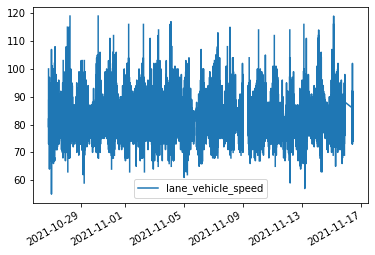

In [36]:
fig = plt.figure(figsize=(16,8), dpi=120)
D2.plot(y='lane_vehicle_speed', use_index=True, backend='matplotlib')

In [37]:
# same thing with 2021-11-05 15:46 to 20:03
# add a day
newdf = D2.loc['2021-11-04 15:45' : '2021-11-04 20:04'].copy()
newindex = newdf.index.values
newdf.index = pd.DatetimeIndex([dt + pd.Timedelta('1D') for dt in newindex])
# concatenate, sort_index
D2 = pd.concat([D2, newdf])
D2.sort_index(inplace=True)
# check with plot
D2.hvplot.line(y='lane_vehicle_speed', use_index=True, width=1300)

C:\Users\David\AppData\Local\Temp/ipykernel_6288/1880543427.py:3: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  newdf = D2.loc['2021-11-04 15:45' : '2021-11-04 20:04'].copy()


:Curve   [index]   (lane_vehicle_speed)

In [38]:
# same thing with 2021-11-08 12:23 to 15:23
# add a day
newdf = D2.loc['2021-11-07 12:22' : '2021-11-07 15:24'].copy()
newindex = newdf.index.values
newdf.index = pd.DatetimeIndex([dt + pd.Timedelta('1D') for dt in newindex])
# concatenate, sort_index
D2 = pd.concat([D2, newdf])
D2.sort_index(inplace=True)
# check with plot
D2.hvplot.line(y='lane_vehicle_speed', use_index=True, width=1300)

C:\Users\David\AppData\Local\Temp/ipykernel_6288/2578557417.py:3: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  newdf = D2.loc['2021-11-07 12:22' : '2021-11-07 15:24'].copy()


:Curve   [index]   (lane_vehicle_speed)

In [39]:
# same thing with 2021-11-09 00:03 to 08:12
# add a day
newdf = D2.loc['2021-11-08 00:02' : '2021-11-08 08:13'].copy()
newindex = newdf.index.values
newdf.index = pd.DatetimeIndex([dt + pd.Timedelta('1D') for dt in newindex])
# concatenate, sort_index
D2 = pd.concat([D2, newdf])
D2.sort_index(inplace=True)
# check with plot
D2.hvplot.line(y='lane_vehicle_speed', use_index=True, width=1300)

C:\Users\David\AppData\Local\Temp/ipykernel_6288/1484982418.py:3: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  newdf = D2.loc['2021-11-08 00:02' : '2021-11-08 08:13'].copy()


:Curve   [index]   (lane_vehicle_speed)

In [40]:
# truncate after 11/15 21:00
D2 = D2.iloc[:-1]
D2.sort_index(inplace=True)

In [41]:
D2 = D2.truncate(after=pd.Timestamp('2021-11-15 21:00'))
D2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 28083 entries, 2021-10-26 20:01:27 to 2021-11-15 20:59:10
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   lane_vehicle_speed     25271 non-null  float64
 1   lane_vehicle_count     28083 non-null  float64
 2   occupancy              28083 non-null  float64
 3   ds_lane_vehicle_speed  25297 non-null  float64
 4   ds_lane_vehicle_count  28083 non-null  int64  
 5   ds_occupancy           28083 non-null  int64  
 6   us_lane_vehicle_speed  25188 non-null  float64
 7   us_lane_vehicle_count  28083 non-null  int64  
 8   us_occupancy           28083 non-null  int64  
dtypes: float64(5), int64(4)
memory usage: 2.1 MB


In [42]:
# just in case, remove duplicates
D2 = D2[~D2.index.duplicated(keep='first')]

In [43]:
D2.hvplot.line(y='lane_vehicle_speed', use_index=True, width=1300)

:Curve   [index]   (lane_vehicle_speed)

## Resample data

! warning. resampling is just a groupby wrt time. ideally we would
create a new x-minute index and do a proper interpolation using scipy, 
but for now we'll just go with the resampling that pandas gives us.

In [44]:
Data = D2.resample('10T', label='right', closed='right').mean().interpolate()

In [45]:
Data.head()

lane_vehicle_speed  lane_vehicle_count  occupancy  \
2021-10-26 20:10:00           85.125000            2.888889   0.333333   
2021-10-26 20:20:00           81.400000            2.500000   0.200000   
2021-10-26 20:30:00           79.375000            2.900000   0.400000   
2021-10-26 20:40:00           84.444444            2.900000   0.500000   
2021-10-26 20:50:00           81.555556            2.666667   0.222222   

                     ds_lane_vehicle_speed  ds_lane_vehicle_count  \
2021-10-26 20:10:00              83.375000               2.555556   
2021-10-26 20:20:00              80.555556               2.700000   
2021-10-26 20:30:00              82.250000               2.800000   
2021-10-26 20:40:00              84.200000               2.500000   
2021-10-26 20:50:00              83.625000               2.222222   

                     ds_occupancy  us_lane_vehicle_speed  \
2021-10-26 20:10:00      0.333333              81.444444   
2021-10-26 20:20:00      0.500000              78.444444   
2021-10-26 20:30:00      0.500000              79.333333   
2021-10-26 20:40:00      0.300000              83.888889   
2021-10-26 20:50:00      0.333333              81.250000   

                     us_lane_vehicle_count  us_occupancy  
2021-10-26 20:10:00               3.000000      0.555556  
2021-10-26 20:20:00               2.600000      0.500000  
2021-10-26 20:30:00               2.700000      0.600000  
2021-10-26 20:40:00               1.900000      0.300000  
2021-10-26 20:50:00               3.111111      0.777778

In [46]:
Data.tail()

lane_vehicle_speed  lane_vehicle_count  occupancy  \
2021-11-15 20:20:00           85.875000            4.000000   0.625000   
2021-11-15 20:30:00           80.444444            4.222222   0.666667   
2021-11-15 20:40:00           79.750000            3.700000   0.600000   
2021-11-15 20:50:00           82.375000            4.500000   0.750000   
2021-11-15 21:00:00           82.600000            3.900000   0.600000   

                     ds_lane_vehicle_speed  ds_lane_vehicle_count  \
2021-11-15 20:20:00              84.857143                   3.00   
2021-11-15 20:30:00              80.777778                   4.00   
2021-11-15 20:40:00              80.700000                   4.00   
2021-11-15 20:50:00              81.500000                   4.25   
2021-11-15 21:00:00              81.100000                   4.20   

                     ds_occupancy  us_lane_vehicle_speed  \
2021-11-15 20:20:00      0.500000              83.125000   
2021-11-15 20:30:00      0.777778              77.111111   
2021-11-15 20:40:00      0.800000              78.777778   
2021-11-15 20:50:00      0.875000              81.142857   
2021-11-15 21:00:00      0.900000              79.900000   

                     us_lane_vehicle_count  us_occupancy  
2021-11-15 20:20:00               2.625000      0.500000  
2021-11-15 20:30:00               3.666667      0.888889  
2021-11-15 20:40:00               4.000000      1.100000  
2021-11-15 20:50:00               3.125000      0.625000  
2021-11-15 21:00:00               4.100000      0.900000

In [47]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2886 entries, 2021-10-26 20:10:00 to 2021-11-15 21:00:00
Freq: 10T
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   lane_vehicle_speed     2886 non-null   float64
 1   lane_vehicle_count     2886 non-null   float64
 2   occupancy              2886 non-null   float64
 3   ds_lane_vehicle_speed  2886 non-null   float64
 4   ds_lane_vehicle_count  2886 non-null   float64
 5   ds_occupancy           2886 non-null   float64
 6   us_lane_vehicle_speed  2886 non-null   float64
 7   us_lane_vehicle_count  2886 non-null   float64
 8   us_occupancy           2886 non-null   float64
dtypes: float64(9)
memory usage: 225.5 KB


In [48]:
# Data.to_excel(Path('c:/projects/nrel-presentation/working/Data.xlsx'))
Data = pd.read_excel(Path('c:/projects/nrel-presentation/working/Data.xlsx'), index_col=[0])

In [49]:
Data

lane_vehicle_speed  lane_vehicle_count  occupancy  \
2021-10-26 20:10:00           85.125000            2.888889   0.333333   
2021-10-26 20:20:00           81.400000            2.500000   0.200000   
2021-10-26 20:30:00           79.375000            2.900000   0.400000   
2021-10-26 20:40:00           84.444444            2.900000   0.500000   
2021-10-26 20:50:00           81.555556            2.666667   0.222222   
...                                 ...                 ...        ...   
2021-11-15 20:20:00           85.875000            4.000000   0.625000   
2021-11-15 20:30:00           80.444444            4.222222   0.666667   
2021-11-15 20:40:00           79.750000            3.700000   0.600000   
2021-11-15 20:50:00           82.375000            4.500000   0.750000   
2021-11-15 21:00:00           82.600000            3.900000   0.600000   

                     ds_lane_vehicle_speed  ds_lane_vehicle_count  \
2021-10-26 20:10:00              83.375000               2.555556   
2021-10-26 20:20:00              80.555556               2.700000   
2021-10-26 20:30:00              82.250000               2.800000   
2021-10-26 20:40:00              84.200000               2.500000   
2021-10-26 20:50:00              83.625000               2.222222   
...                                    ...                    ...   
2021-11-15 20:20:00              84.857143               3.000000   
2021-11-15 20:30:00              80.777778               4.000000   
2021-11-15 20:40:00              80.700000               4.000000   
2021-11-15 20:50:00              81.500000               4.250000   
2021-11-15 21:00:00              81.100000               4.200000   

                     ds_occupancy  us_lane_vehicle_speed  \
2021-10-26 20:10:00      0.333333              81.444444   
2021-10-26 20:20:00      0.500000              78.444444   
2021-10-26 20:30:00      0.500000              79.333333   
2021-10-26 20:40:00      0.300000              83.888889   
2021-10-26 20:50:00      0.333333              81.250000   
...                           ...                    ...   
2021-11-15 20:20:00      0.500000              83.125000   
2021-11-15 20:30:00      0.777778              77.111111   
2021-11-15 20:40:00      0.800000              78.777778   
2021-11-15 20:50:00      0.875000              81.142857   
2021-11-15 21:00:00      0.900000              79.900000   

                     us_lane_vehicle_count  us_occupancy  
2021-10-26 20:10:00               3.000000      0.555556  
2021-10-26 20:20:00               2.600000      0.500000  
2021-10-26 20:30:00               2.700000      0.600000  
2021-10-26 20:40:00               1.900000      0.300000  
2021-10-26 20:50:00               3.111111      0.777778  
...                                    ...           ...  
2021-11-15 20:20:00               2.625000      0.500000  
2021-11-15 20:30:00               3.666667      0.888889  
2021-11-15 20:40:00               4.000000      1.100000  
2021-11-15 20:50:00               3.125000      0.625000  
2021-11-15 21:00:00               4.100000      0.900000  

[2886 rows x 9 columns]

In [50]:
Data.isnull().sum()

lane_vehicle_speed       0
lane_vehicle_count       0
occupancy                0
ds_lane_vehicle_speed    0
ds_lane_vehicle_count    0
ds_occupancy             0
us_lane_vehicle_speed    0
us_lane_vehicle_count    0
us_occupancy             0
dtype: int64

## Add features

from timestamp:
- hour of day
- sin/cos (hour of day)
- day of week (one-hot encoding)
- sin(day of year / 365 * 2 * pi)
- cos(day of year / 365 * 2 * pi)

In [51]:
# hour of day
hod = Data.index.hour
Data['hod'] = hod
Data['sin_hod'] = np.sin((hod+1) / 24 * 2 * np.pi)
Data['cos_hod'] = np.cos((hod+1) / 24 * 2 * np.pi)

In [52]:
# day of week
#  use one-hot encoding with 6 values
dow = np.array([str(i) for i in Data.index.weekday.values]).T
s = pd.Series(dow)
tmp = pd.get_dummies(s, drop_first=True)
tmp.columns = ['is_dow_{}'.format(this_col) for this_col in tmp.columns]
for col in tmp.columns:
    Data[col] = tmp[col].values

In [53]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2886 entries, 2021-10-26 20:10:00 to 2021-11-15 21:00:00
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   lane_vehicle_speed     2886 non-null   float64
 1   lane_vehicle_count     2886 non-null   float64
 2   occupancy              2886 non-null   float64
 3   ds_lane_vehicle_speed  2886 non-null   float64
 4   ds_lane_vehicle_count  2886 non-null   float64
 5   ds_occupancy           2886 non-null   float64
 6   us_lane_vehicle_speed  2886 non-null   float64
 7   us_lane_vehicle_count  2886 non-null   float64
 8   us_occupancy           2886 non-null   float64
 9   hod                    2886 non-null   int64  
 10  sin_hod                2886 non-null   float64
 11  cos_hod                2886 non-null   float64
 12  is_dow_1               2886 non-null   uint8  
 13  is_dow_2               2886 non-null   uint8  
 14  is_dow_3            

In [54]:
# day of year
#   use sin/cos
doy = Data.index.day_of_year
Data['sin_doy'] = np.sin((doy+1) / 365 * 2 * np.pi)
Data['cos_doy'] = np.cos((doy+1) / 365 * 2 * np.pi)

In [55]:
Data.tail()

lane_vehicle_speed  lane_vehicle_count  occupancy  \
2021-11-15 20:20:00           85.875000            4.000000   0.625000   
2021-11-15 20:30:00           80.444444            4.222222   0.666667   
2021-11-15 20:40:00           79.750000            3.700000   0.600000   
2021-11-15 20:50:00           82.375000            4.500000   0.750000   
2021-11-15 21:00:00           82.600000            3.900000   0.600000   

                     ds_lane_vehicle_speed  ds_lane_vehicle_count  \
2021-11-15 20:20:00              84.857143                   3.00   
2021-11-15 20:30:00              80.777778                   4.00   
2021-11-15 20:40:00              80.700000                   4.00   
2021-11-15 20:50:00              81.500000                   4.25   
2021-11-15 21:00:00              81.100000                   4.20   

                     ds_occupancy  us_lane_vehicle_speed  \
2021-11-15 20:20:00      0.500000              83.125000   
2021-11-15 20:30:00      0.777778              77.111111   
2021-11-15 20:40:00      0.800000              78.777778   
2021-11-15 20:50:00      0.875000              81.142857   
2021-11-15 21:00:00      0.900000              79.900000   

                     us_lane_vehicle_count  us_occupancy  hod   sin_hod  \
2021-11-15 20:20:00               2.625000      0.500000   20 -0.707107   
2021-11-15 20:30:00               3.666667      0.888889   20 -0.707107   
2021-11-15 20:40:00               4.000000      1.100000   20 -0.707107   
2021-11-15 20:50:00               3.125000      0.625000   20 -0.707107   
2021-11-15 21:00:00               4.100000      0.900000   21 -0.500000   

                      cos_hod  is_dow_1  is_dow_2  is_dow_3  is_dow_4  \
2021-11-15 20:20:00  0.707107         0         0         0         0   
2021-11-15 20:30:00  0.707107         0         0         0         0   
2021-11-15 20:40:00  0.707107         0         0         0         0   
2021-11-15 20:50:00  0.707107         0         0         0         0   
2021-11-15 21:00:00  0.866025         0         0         0         0   

                     is_dow_5  is_dow_6   sin_doy   cos_doy  
2021-11-15 20:20:00         0         0 -0.699458  0.714673  
2021-11-15 20:30:00         0         0 -0.699458  0.714673  
2021-11-15 20:40:00         0         0 -0.699458  0.714673  
2021-11-15 20:50:00         0         0 -0.699458  0.714673  
2021-11-15 21:00:00         0         0 -0.699458  0.714673

In [56]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2886 entries, 2021-10-26 20:10:00 to 2021-11-15 21:00:00
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   lane_vehicle_speed     2886 non-null   float64
 1   lane_vehicle_count     2886 non-null   float64
 2   occupancy              2886 non-null   float64
 3   ds_lane_vehicle_speed  2886 non-null   float64
 4   ds_lane_vehicle_count  2886 non-null   float64
 5   ds_occupancy           2886 non-null   float64
 6   us_lane_vehicle_speed  2886 non-null   float64
 7   us_lane_vehicle_count  2886 non-null   float64
 8   us_occupancy           2886 non-null   float64
 9   hod                    2886 non-null   int64  
 10  sin_hod                2886 non-null   float64
 11  cos_hod                2886 non-null   float64
 12  is_dow_1               2886 non-null   uint8  
 13  is_dow_2               2886 non-null   uint8  
 14  is_dow_3            

In [57]:
# export intermediate data
Data.to_excel(Path('c:/projects/nrel-presentation/working/Data_unscaled_with_features.xlsx'))

In [63]:
# plot
raw_data_with_features = Data.hvplot(subplots=True, width=1200, height=150, shared_axes=False).cols(1)
raw_data_with_features

:NdLayout   [Variable]
   :Curve   [index]   (value)

In [66]:
hv.save(raw_data_with_features, root_dir / 'reports/figures/raw_data_with_features.png', fmt='png')

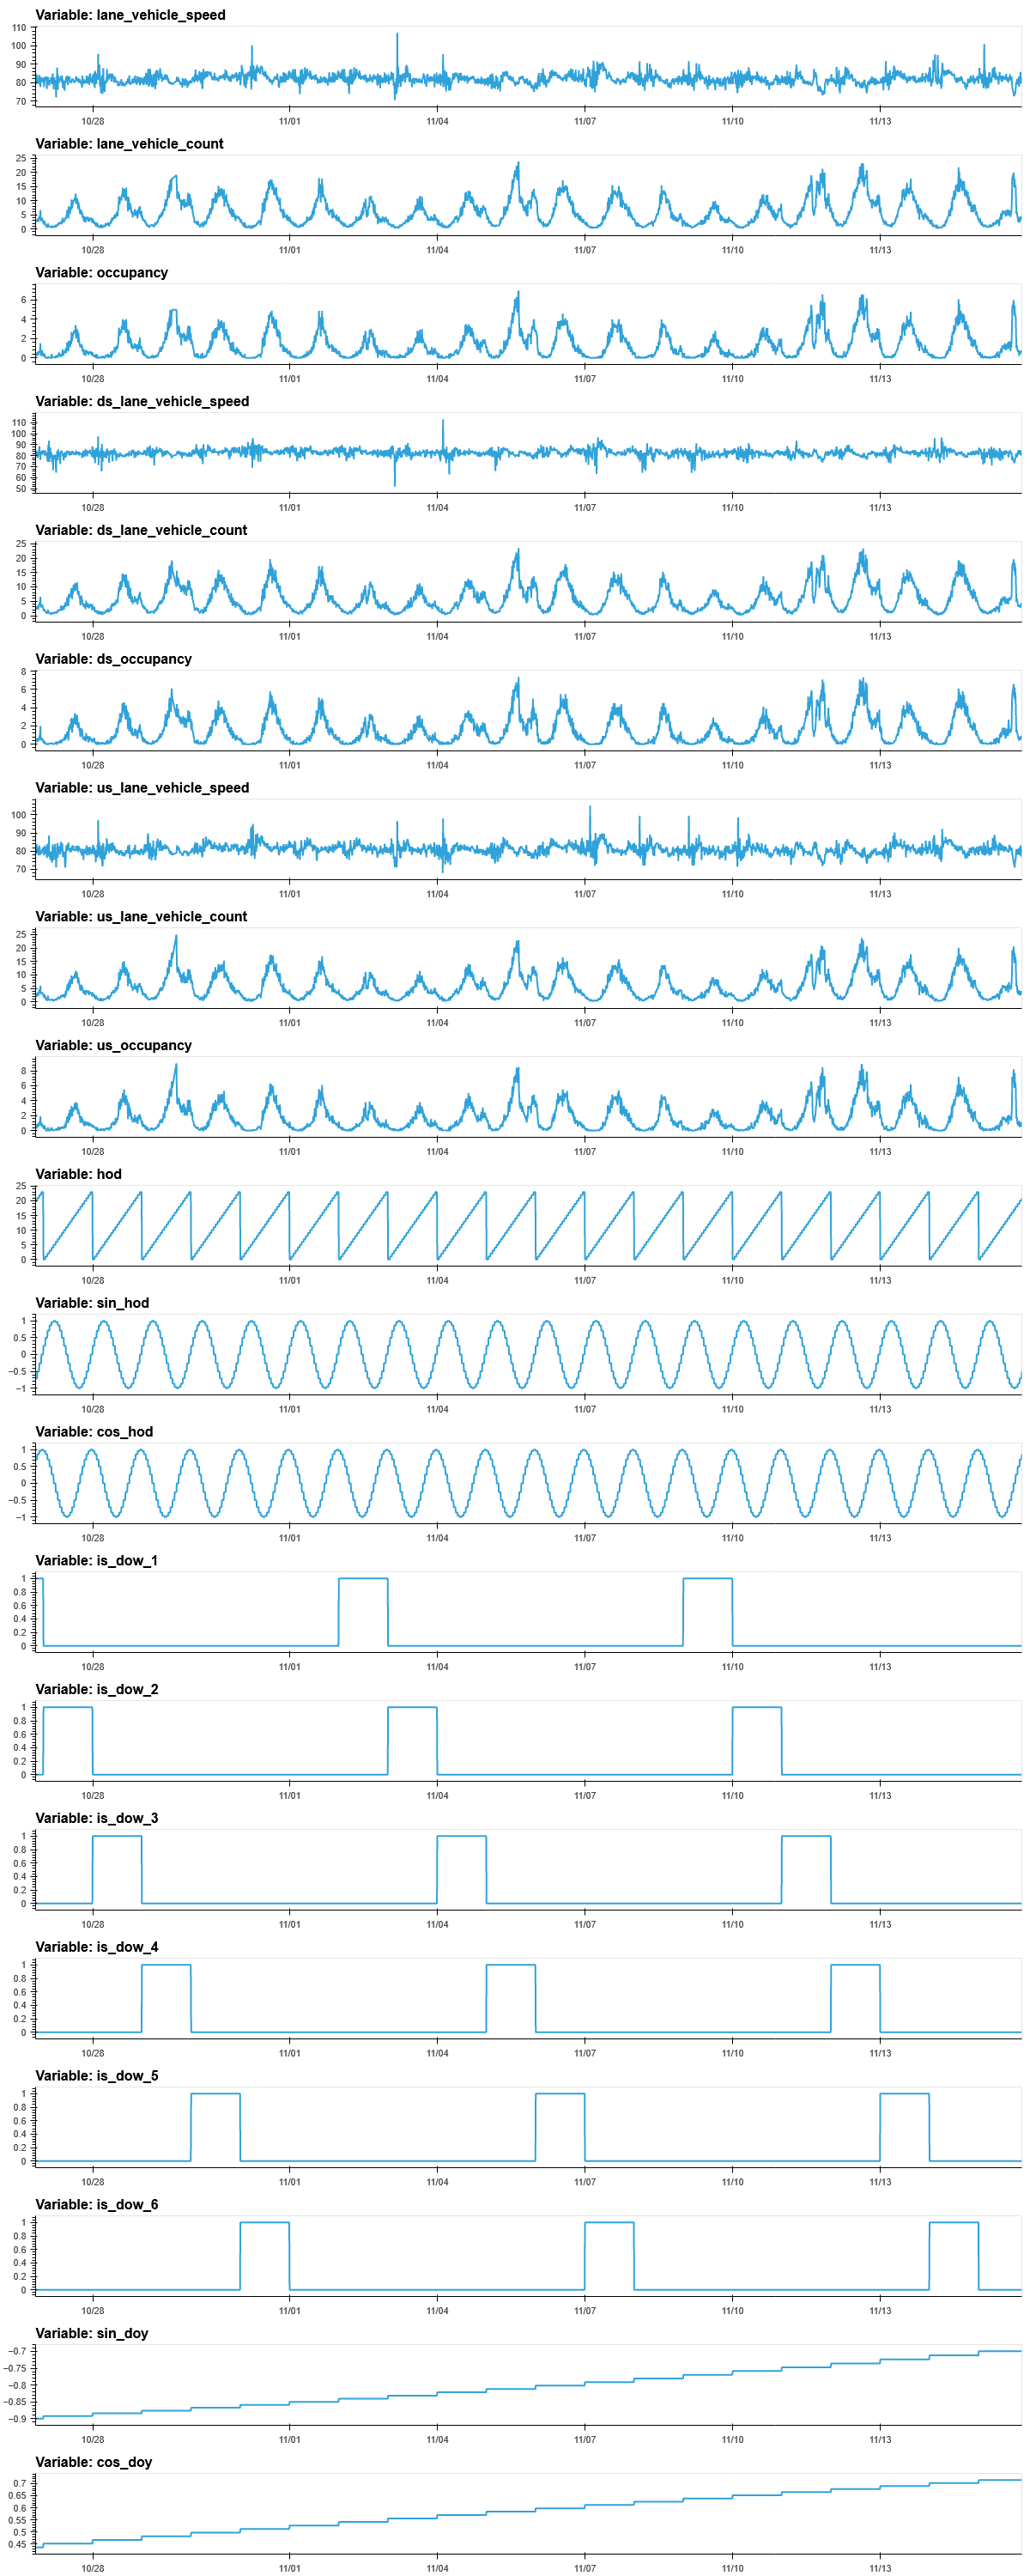

In [69]:
Image(root_dir / 'reports/figures/raw_data_with_features.png')

In [70]:
raw_data_with_features_histogram = Data.hvplot.hist(subplots=True, width=300, height=150, shared_axes=False).cols(4)
raw_data_with_features_histogram

:NdLayout   [Default]
   :Histogram   [cos_doy]   (cos_doy_count)

In [71]:
hv.save(raw_data_with_features_histogram, root_dir / 'reports/figures/raw_data_with_features_histogram.png', fmt='png')

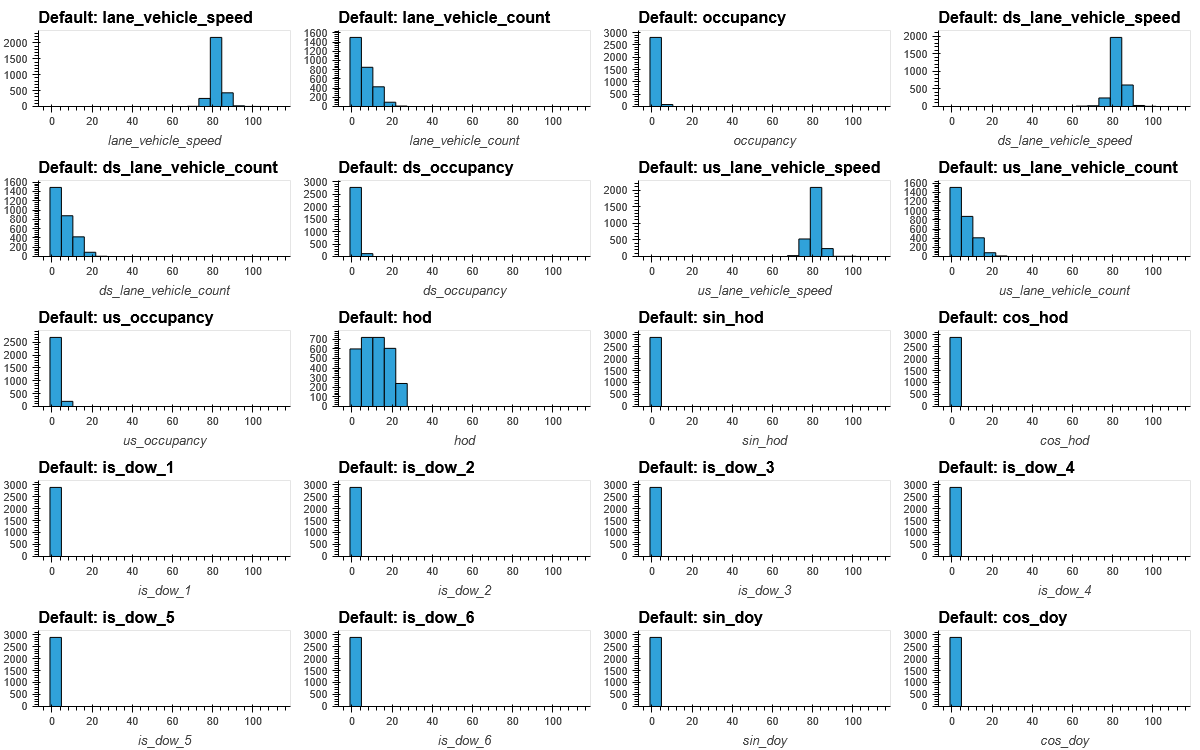

In [72]:
Image(root_dir / 'reports/figures/raw_data_with_features_histogram.png')

## Save

In [73]:
# export unscaled data with features
Data.to_parquet(root_dir / 'data/processed/Data_unscaled_with_features.pq')